# IA classificadora de texto

## Parte 0: Instalação e inicialização dos pacotes necessários

In [1]:
%pip install spacy transformers 

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install nltk pandas scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install 'tensorflow[and-cuda]'

Note: you may need to restart the kernel to use updated packages.


In [5]:
import warnings
warnings.filterwarnings('ignore')

import math 
import nltk
import spacy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from keras.utils import to_categorical
from keras import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import Precision, Recall, AUC
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau
from keras.optimizers import Adam

2024-01-23 07:18:42.843488: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-23 07:18:42.905564: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 07:18:42.905590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 07:18:42.906729: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 07:18:42.915837: I tensorflow/core/platform/cpu_feature_guar

In [6]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-01-23 07:18:45.880553: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-23 07:18:45.915495: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-23 07:18:45.915650: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Modelo 1 - Fully connected neural network

### Parte 1.1: Pré-processamento de dados do input

In [7]:
data_train = pd.read_csv('dados_treino.txt', header=None, delimiter=';')
data_test = pd.read_csv('dados_teste.txt', header=None, delimiter=';')

In [8]:
data_train.rename(columns={0: 'text', 1: 'sentiment'}, inplace=True)
data_test.rename(columns={0: 'text', 1: 'sentiment'}, inplace=True)

In [9]:
print('shape train data: {}\nshape test data: {}'.format(data_train.shape, data_test.shape))

shape train data: (16000, 2)
shape test data: (2000, 2)


In [10]:
data_train.head()

,text,sentiment
0,i am feeling completely overwhelmed i have two...,fear
1,i have the feeling she was amused and delighted,joy
2,i was able to help chai lifeline with your sup...,joy
3,i already feel like i fucked up though because...,anger
4,i still love my so and wish the best for him i...,sadness


In [11]:
data_test.head()

,text,sentiment
0,i feel like my only role now would be to tear ...,sadness
1,i feel just bcoz a fight we get mad to each ot...,anger
2,i feel like reds and purples are just so rich ...,joy
3,im not sure the feeling of loss will ever go a...,sadness
4,i feel like ive gotten to know many of you thr...,joy


In [12]:
data_train['sentiment'].value_counts()

sentiment
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [13]:
data_test['sentiment'].value_counts()

sentiment
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

In [14]:
!python -m spacy download en_core_web_md -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [15]:
nlp = spacy.load('en_core_web_md')

In [16]:
def process_text(text: str) -> str:
    doc = nlp(text)
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]
    return ' '.join(tokens)

In [17]:
data_train['processed_text'] = data_train['text'].apply(process_text)

In [18]:
data_train.head()

,text,sentiment,processed_text
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


In [19]:
data_test['processed_text'] = data_test['text'].apply(process_text)

In [20]:
data_test.head()

,text,sentiment,processed_text
0,i feel like my only role now would be to tear ...,sadness,feel like role tear sail pessimism discontent
1,i feel just bcoz a fight we get mad to each ot...,anger,feel bcoz fight mad n u wanna publicity n let ...
2,i feel like reds and purples are just so rich ...,joy,feel like red purple rich kind perfect
3,im not sure the feeling of loss will ever go a...,sadness,m sure feeling loss away dull sweet feeling no...
4,i feel like ive gotten to know many of you thr...,joy,feel like ve get know comment email m apprecia...


In [21]:
tf_idf = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words='english')

In [22]:
tfidf_train = tf_idf.fit_transform(data_train['processed_text'])
tfidf_test = tf_idf.transform(data_test['processed_text'])

In [23]:
print(f"shape training data: {tfidf_train.shape}\nshape test data: {tfidf_test.shape}")

shape training data: (16000, 5586)
shape test data: (2000, 5586)


In [24]:
X_train = tfidf_train.toarray()
X_test = tfidf_test.toarray()

### Parte 1.2: Pré-processamento dos dados de output

In [25]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(data_train['sentiment'])
y_test = label_encoder.transform(data_test['sentiment'])

In [26]:
weights = compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)

type(weights)

numpy.ndarray

In [27]:
X_training, X_valid, y_training, y_valid = train_test_split(X_train, 
                                                            y_train,
                                                            test_size = 0.2, 
                                                            random_state = 42, 
                                                            stratify=y_train)

y_training_encoded = to_categorical(y_training)
y_valid_encoded = to_categorical(y_valid)
y_test_encoded = to_categorical(y_test)


In [28]:
print(y_training, y_training_encoded)
type(y_training_encoded)

[4 2 2 ... 4 2 2] [[0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


numpy.ndarray

### Parte 2: Criação do modelo

In [29]:
activation, initializer, input_shape, regularizer = 'selu', 'lecun_normal', (X_training.shape[1],), keras.regularizers.l2(0.01)
regularizer_2 = keras.regularizers.l2(0.1)

In [30]:
fcnn = Sequential([
    Dense(4096, 
          activation=activation,
          kernel_initializer=initializer, 
          input_shape=(input_shape),
          kernel_regularizer=regularizer
          ),
    Dense(2048, 
          activation=activation,
          kernel_initializer=initializer, 
          kernel_regularizer=regularizer
          ),
    Dense(1024, 
          activation=activation,
          kernel_initializer=initializer, 
          kernel_regularizer=regularizer_2
          ),
    Dense(64, activation=activation),
    Dense(6, activation='softmax')
])

2024-01-23 07:20:18.529690: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-23 07:20:18.530216: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-23 07:20:18.530352: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [31]:
fcnn.layers[-1].bias.assign(weights)

<tf.Variable 'UnreadVariable' shape=(6,) dtype=float32, numpy=
array([1.2351397 , 1.3766993 , 0.49732688, 2.0449898 , 0.5715102 ,
       4.6620045 ], dtype=float32)>

In [32]:
fcnn.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
fcnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              22884352  
                                                                 
 dense_1 (Dense)             (None, 2048)              8390656   
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_3 (Dense)             (None, 64)                65600     
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
Total params: 33439174 (127.56 MB)
Trainable params: 33439174 (127.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
l_rate_0 = 0.001
drop = 0.5
epochs_drop = 10

lr_scheduler = LearningRateScheduler(lambda epoch: l_rate_0 * math.pow(drop, math.floor(((1+ epoch) / epochs_drop))))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [35]:
epochs = 20
batch_size = 256

In [36]:
%%time
history = fcnn.fit(X_training,
                   y_training_encoded,
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_data=(X_valid, y_valid_encoded),
                   callbacks=[early_stopping, lr_scheduler]
                   )

Epoch 1/20


2024-01-23 07:20:21.435422: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-23 07:20:21.474724: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa7ebec6a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-23 07:20:21.474740: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-01-23 07:20:21.478468: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-23 07:20:21.718771: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1706005221.780301   40551 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 [==============================] - 4s 25ms/step - loss: 36.8589 - accuracy: 0.6784 - val_loss: 2.2892 - val_accuracy: 0.7559 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 1s 19ms/step - loss: 1.4851 - accuracy: 0.8034 - val_loss: 1.3448 - val_accuracy: 0.7941 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 1s 19ms/step - loss: 1.2079 - accuracy: 0.8220 - val_loss: 1.1846 - val_accuracy: 0.8178 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 1s 19ms/step - loss: 1.0585 - accuracy: 0.8520 - val_loss: 1.1628 - val_accuracy: 0.8159 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 1s 19ms/step - loss: 0.9770 - accuracy: 0.8731 - val_loss: 1.0719 - val_accuracy: 0.8369 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 1s 18ms/step - loss: 0.8938 - accuracy: 0.8948 - val_loss: 1.0788 - val_accuracy: 0.8334 - lr: 0.0010
Epoch 7/20
50/50 [==============================] - 1s 18ms/step - loss: 0.8653 - accu

### Parte 3: análise do desempenho do modelo 

In [37]:
loss, val_loss = history.history['loss'], history.history['val_loss']

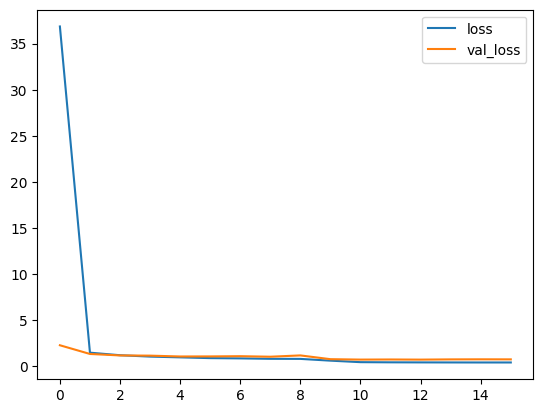

In [38]:
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

In [39]:
predict_v1 = fcnn.predict(X_test)

63/63 [==============================] - 0s 1ms/step


In [40]:
predict_v1.argmax(axis=1)

array([4, 0, 2, ..., 2, 2, 1])

In [41]:
report = classification_report(y_test, predict_v1.argmax(axis=1), output_dict=True)

In [42]:
pd.DataFrame(report).T

,precision,recall,f1-score,support
0,0.819728,0.876364,0.847100,275.0000
1,0.855670,0.741071,0.794258,224.0000
2,0.868603,0.903597,0.885755,695.0000
3,0.722581,0.704403,0.713376,159.0000
4,0.883362,0.886403,0.884880,581.0000
5,0.764706,0.590909,0.666667,66.0000
accuracy,0.850500,0.850500,0.850500,0.8505
macro avg,0.819108,0.783791,0.798673,2000.0000
weighted avg,0.849684,0.850500,0.849004,2000.0000


In [43]:
# fcnn.save('first_model_v1.keras')

In [44]:
frase = 'I am stronger than ever'

exemplo = pd.DataFrame({'text': [frase]})

exemplo['processed_text'] = exemplo['text'].apply(process_text)

exemplo_model = tf_idf.transform(exemplo['processed_text']).toarray()

exemplo_model

array([[0., 0., 0., ..., 0., 0., 0.]])

In [45]:
label_encoder.inverse_transform(fcnn.predict(exemplo_model).argmax(axis=1))

1/1 [==============================] - 0s 16ms/step


array(['joy'], dtype=object)

### Parte 4: Otimização da entrada de dados ao modelo

In [46]:
class Model: 
    def __init__(self, preprocess, model, postprocess) -> None:
        self.preprocess = preprocess
        self.model = model
        self.postprocess = postprocess

    def predict(self, text: str) -> str:
        input = self.preprocess(text)
        output = self.model.predict(input)
        return self.postprocess(output)        

    __call__ = predict

In [47]:
def preprocessing_v1(text: str) -> np.ndarray:
    tmp = text
    if isinstance(text, str):
        tmp = pd.DataFrame({'text': [text]})['text']
    tmp['processed_text'] = tmp.apply(process_text)
    input = tf_idf.transform(tmp['processed_text']).toarray()
    return input

def postprocessing_v1(output: np.ndarray) -> str:
    return label_encoder.inverse_transform(output.argmax(axis=1))[0]

model_v0 = Model(preprocessing_v1, fcnn, postprocessing_v1)
model_v0('I feel a little shaky')

1/1 [==============================] - 0s 15ms/step


'fear'

### Parte 5: Otimização do modelo

Opção 1: Modificando a função de ativação

In [48]:
activation = 'relu'

In [49]:
fcnn_v2 = Sequential([
    Dense(4096, 
          activation=activation,
          kernel_initializer=initializer, 
          input_shape=(input_shape),
          kernel_regularizer=regularizer
          ),
    Dense(2048, 
          activation=activation,
          kernel_initializer=initializer, 
          kernel_regularizer=regularizer
          ),
    Dense(1024, 
          activation=activation,
          kernel_initializer=initializer, 
          kernel_regularizer=regularizer_2
          ),
    Dense(64, activation=activation),
    Dense(6, activation='softmax')
])

fcnn_v2.layers[-1].bias.assign(weights)

fcnn_v2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

fcnn_v2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 4096)              22884352  
                                                                 
 dense_6 (Dense)             (None, 2048)              8390656   
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_8 (Dense)             (None, 64)                65600     
                                                                 
 dense_9 (Dense)             (None, 6)                 390       
                                                                 
Total params: 33439174 (127.56 MB)
Trainable params: 33439174 (127.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
history2 = fcnn_v2.fit(X_training,
            y_training_encoded,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_valid, y_valid_encoded),
            callbacks=[early_stopping, lr_scheduler]
            )

Epoch 1/20
50/50 [==============================] - 2s 24ms/step - loss: 36.6601 - accuracy: 0.2604 - val_loss: 2.4825 - val_accuracy: 0.3350 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 1s 19ms/step - loss: 1.7863 - accuracy: 0.3352 - val_loss: 1.6293 - val_accuracy: 0.3350 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 1s 19ms/step - loss: 1.6150 - accuracy: 0.3327 - val_loss: 1.5898 - val_accuracy: 0.3350 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 1s 19ms/step - loss: 1.5836 - accuracy: 0.3352 - val_loss: 1.5817 - val_accuracy: 0.3350 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 1s 19ms/step - loss: 1.5789 - accuracy: 0.3352 - val_loss: 1.5797 - val_accuracy: 0.3350 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 1s 19ms/step - loss: 1.5775 - accuracy: 0.3352 - val_loss: 1.5777 - val_accuracy: 0.3350 - lr: 0.0010
Epoch 7/20
50/50 [==============================] - 1s 18ms/step - loss: 1.

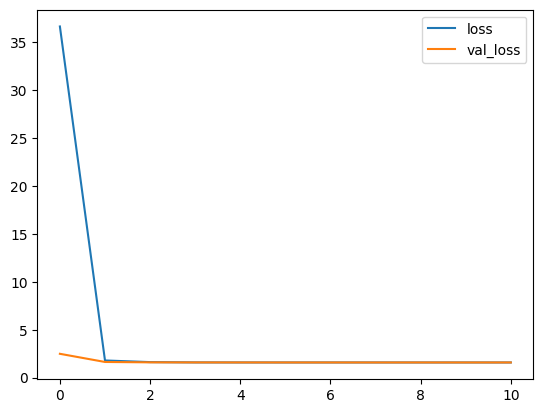

In [51]:
loss2, val_loss2 = history2.history['loss'], history2.history['val_loss']

plt.plot(loss2, label='loss')
plt.plot(val_loss2, label='val_loss')
plt.legend()
plt.show()

Testando mudança no número de neurônios

In [52]:
activation = 'selu'

fcnn_v3 = Sequential([
    Dense(4096, 
          activation=activation,
          kernel_initializer=initializer, 
          input_shape=(input_shape),
          kernel_regularizer=regularizer
          ),
    Dense(4096, 
          activation=activation,
          kernel_initializer=initializer, 
          kernel_regularizer=regularizer
          ),
    Dense(2048, 
          activation=activation,
          kernel_initializer=initializer, 
          kernel_regularizer=regularizer
          ),
    Dense(1024, 
          activation=activation,
          kernel_initializer=initializer, 
          kernel_regularizer=regularizer_2
          ),
    Dense(64, activation=activation),
    Dense(6, activation='softmax')
])

fcnn_v3.layers[-1].bias.assign(weights)

fcnn_v3.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

fcnn_v3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 4096)              22884352  
                                                                 
 dense_11 (Dense)            (None, 4096)              16781312  
                                                                 
 dense_12 (Dense)            (None, 2048)              8390656   
                                                                 
 dense_13 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_14 (Dense)            (None, 64)                65600     
                                                                 
 dense_15 (Dense)            (None, 6)                 390       
                                                                 
Total params: 50220486 (191.58 MB)
Trainable params: 5

In [53]:
history3 = fcnn_v3.fit(X_training,
                       y_training_encoded,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(X_valid, y_valid_encoded),
                       callbacks=[early_stopping, lr_scheduler]
                       )

Epoch 1/20
50/50 [==============================] - 3s 34ms/step - loss: 47.9954 - accuracy: 0.6691 - val_loss: 2.6907 - val_accuracy: 0.7694 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 1s 29ms/step - loss: 1.6160 - accuracy: 0.8018 - val_loss: 1.3785 - val_accuracy: 0.8059 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 1s 29ms/step - loss: 1.1993 - accuracy: 0.8437 - val_loss: 1.2474 - val_accuracy: 0.8138 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 1s 27ms/step - loss: 1.0931 - accuracy: 0.8655 - val_loss: 1.2654 - val_accuracy: 0.8066 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 1s 29ms/step - loss: 1.0399 - accuracy: 0.8877 - val_loss: 1.2040 - val_accuracy: 0.8256 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 1s 27ms/step - loss: 0.9805 - accuracy: 0.9022 - val_loss: 1.2118 - val_accuracy: 0.8191 - lr: 0.0010
Epoch 7/20
50/50 [==============================] - 1s 27ms/step - loss: 0.

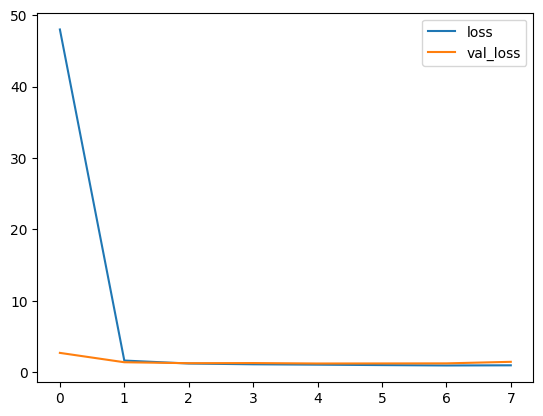

In [54]:
loss3, val_loss3 = history3.history['loss'], history3.history['val_loss']

plt.plot(loss3, label='loss')
plt.plot(val_loss3, label='val_loss')
plt.legend()
plt.show()

Testando mudar a paciência do EarlyStopping

In [55]:
new_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

fcnn_v4 = Sequential([
    Dense(4096, 
          activation=activation,
          kernel_initializer=initializer, 
          input_shape=(input_shape),
          kernel_regularizer=regularizer
          ),
    Dense(2048, 
          activation=activation,
          kernel_initializer=initializer, 
          kernel_regularizer=regularizer
          ),
    Dense(1024, 
          activation=activation,
          kernel_initializer=initializer, 
          kernel_regularizer=regularizer_2
          ),
    Dense(64, activation=activation),
    Dense(6, activation='softmax')
])

fcnn_v4.layers[-1].bias.assign(weights)
fcnn_v4.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
fcnn_v4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 4096)              22884352  
                                                                 


 dense_17 (Dense)            (None, 2048)              8390656   
                                                                 
 dense_18 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_19 (Dense)            (None, 64)                65600     
                                                                 
 dense_20 (Dense)            (None, 6)                 390       
                                                                 
Total params: 33439174 (127.56 MB)
Trainable params: 33439174 (127.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
history4 = fcnn_v4.fit(X_training,
                       y_training_encoded,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(X_valid, y_valid_encoded),
                       callbacks=[new_early_stopping, lr_scheduler]
                       )

Epoch 1/20
50/50 [==============================] - 2s 24ms/step - loss: 37.1263 - accuracy: 0.6625 - val_loss: 2.2663 - val_accuracy: 0.7688 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 1s 19ms/step - loss: 1.5136 - accuracy: 0.7831 - val_loss: 1.3942 - val_accuracy: 0.7906 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 1s 19ms/step - loss: 1.2117 - accuracy: 0.8269 - val_loss: 1.2410 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 1s 19ms/step - loss: 1.0495 - accuracy: 0.8554 - val_loss: 1.1768 - val_accuracy: 0.8216 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 1s 19ms/step - loss: 0.9765 - accuracy: 0.8757 - val_loss: 1.1323 - val_accuracy: 0.8331 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 1s 19ms/step - loss: 0.9167 - accuracy: 0.8941 - val_loss: 1.1289 - val_accuracy: 0.8356 - lr: 0.0010
Epoch 7/20
50/50 [==============================] - 1s 18ms/step - loss: 0.

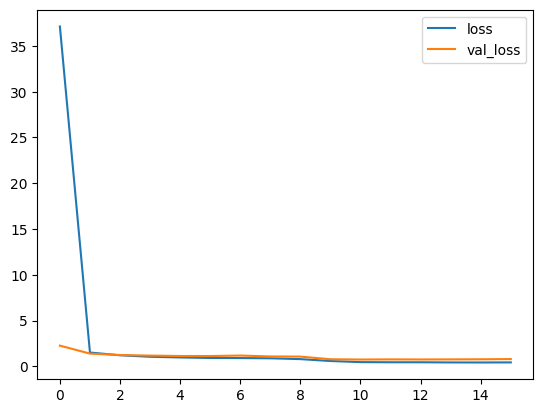

In [57]:
loss4, val_loss4 = history4.history['loss'], history4.history['val_loss']

plt.plot(loss4, label='loss')
plt.plot(val_loss4, label='val_loss')
plt.legend()
plt.show()


## Modelo 2: LSTM

### Parte 1.1: Pré-processamento da entrada

In [58]:
data_train.head()

,text,sentiment,processed_text
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


In [59]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(data_train['processed_text'])


In [60]:
sequence_train = tokenizer.texts_to_sequences(data_train['processed_text'])

In [61]:
max_length = 100
padded_sequence_train = pad_sequences(sequence_train, truncating='post', maxlen=max_length)
type(padded_sequence_train)

numpy.ndarray

In [62]:
def preprocessing_v2(text: str | pd.DataFrame, max_length: int = max_length, tokenizer: Tokenizer = tokenizer) -> np.ndarray:
    tmp = text
    if isinstance(text, str):
        tmp = pd.DataFrame({'text': [text]})['text']
    tmp['processed_text'] = tmp.apply(process_text)
    input = tokenizer.texts_to_sequences(tmp['processed_text'])
    final_input = pad_sequences(input, truncating='post', maxlen=max_length)
    return final_input

### Parte 1.2: Pré-processamento da saída

In [63]:
label_encoder_v2 = LabelEncoder()

y_train_v2 = label_encoder_v2.fit_transform(data_train['sentiment'])
y_test_v2 = label_encoder_v2.transform(data_test['sentiment'])

In [64]:
y_train_v2_encoded = to_categorical(y_train_v2)
y_test_v2_encoded = to_categorical(y_test_v2)

In [65]:
def postprocessing_v2(output: np.ndarray) -> str:
    return label_encoder_v2.inverse_transform(output.argmax(axis=1))[0]

In [66]:
vocab_size = len(tokenizer.word_index) + 1
embed_len = max_length
regularizer = 'l1_l2'
activation = 'leaky_relu'

In [94]:
lstm = Sequential([
    Embedding(vocab_size, embed_len, input_length=max_length),
    Bidirectional(LSTM(64)),
    Dropout(0.4),
    Dense(32, activation=activation, kernel_regularizer=regularizer),
    Dropout(0.4),
    Dense(6, activation='softmax')
])

In [95]:
lstm.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1189700   
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               84480     
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 32)                4128      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_26 (Dense)            (None, 6)                 198       
                                                      

In [96]:
early_stopping_v1 = EarlyStopping(patience=5)
epochs = 35
validation_split = 0.2

In [97]:
history_v1 = lstm.fit(padded_sequence_train,
                      y_train_v2_encoded,
                      epochs=epochs,
                      validation_split=validation_split,
                      callbacks=[early_stopping_v1]
                      )

Epoch 1/35


400/400 [==============================] - 11s 23ms/step - loss: 2.4258 - accuracy: 0.3224 - precision_3: 0.3241 - recall_3: 0.0027 - auc_3: 0.7055 - val_loss: 1.6130 - val_accuracy: 0.3262 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.7307
Epoch 2/35
400/400 [==============================] - 3s 8ms/step - loss: 1.4637 - accuracy: 0.3717 - precision_3: 0.5270 - recall_3: 0.1013 - auc_3: 0.7980 - val_loss: 1.3690 - val_accuracy: 0.3703 - val_precision_3: 0.5000 - val_recall_3: 0.0012 - val_auc_3: 0.8281
Epoch 3/35
400/400 [==============================] - 3s 8ms/step - loss: 1.2600 - accuracy: 0.4271 - precision_3: 0.5281 - recall_3: 0.1930 - auc_3: 0.8557 - val_loss: 1.2557 - val_accuracy: 0.4259 - val_precision_3: 0.5192 - val_recall_3: 0.2447 - val_auc_3: 0.8528
Epoch 4/35
400/400 [==============================] - 3s 7ms/step - loss: 1.1864 - accuracy: 0.4409 - precision_3: 0.5279 - recall_3: 0.2179 - auc_3: 0.8678 - val_loss: 1.2633 - val_accuracy: 0.426

In [98]:
model_v2 = Model(preprocessing_v2, lstm, postprocessing_v2)

In [112]:
model_v2('I am feeling a little bit happy')

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


'joy'

In [78]:
X_test_v2 = tokenizer.texts_to_sequences(data_test['processed_text'])
X_test_v2 = pad_sequences(X_test_v2, truncating='post', maxlen=max_length)
X_test_v2

array([[   0,    0,    0, ...,  506, 5698,  569],
       [   0,    0,    0, ...,   60,    6,  695],
       [   0,    0,    0, ...,  312,   50,  206],
       ...,
       [   0,    0,    0, ...,  132,    5, 2496],
       [   0,    0,    0, ...,   26,  488, 1783],
       [   0,    0,    0, ...,  122,  122, 1641]], dtype=int32)

In [100]:
predict_v2 = lstm.predict(X_test_v2)
print(classification_report(y_test_v2, predict_v2.argmax(axis=1)))

 1/63 [..............................] - ETA: 0s

63/63 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       275
           1       0.83      0.89      0.86       224
           2       0.90      0.89      0.90       695
           3       0.63      0.75      0.68       159
           4       0.93      0.91      0.92       581
           5       0.87      0.50      0.63        66

    accuracy                           0.87      2000
   macro avg       0.84      0.80      0.81      2000
weighted avg       0.87      0.87      0.87      2000



In [113]:
confusion_matrix(y_test_v2, predict_v2.argmax(axis=1))

array([[237,  11,   4,   5,  16,   2],
       [ 14, 200,   3,   0,   5,   2],
       [  4,   1, 621,  54,  14,   1],
       [  2,   4,  30, 119,   4,   0],
       [ 18,   6,  23,   7, 527,   0],
       [  1,  20,   7,   4,   1,  33]])

In [114]:
accuracy_score(y_test_v2, predict_v2.argmax(axis=1))

0.8685

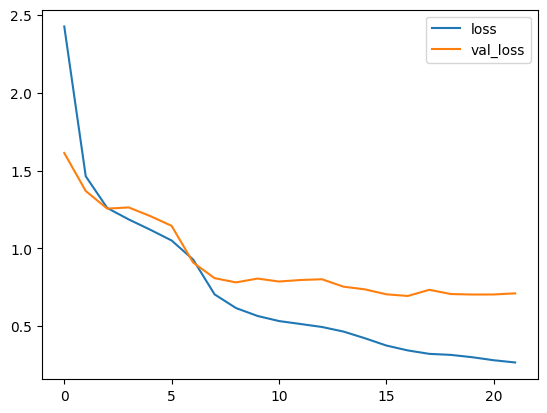

In [101]:
plt.plot(history_v1.history['loss'], label='loss')
plt.plot(history_v1.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
lstm.save('model_v2.keras')